In this notebook, we work to build our main dataframe containing listings from LA and all of their metadata features to be used in our models.

Includes: 
* Merging additional datasets to combat missingness - supplement REX listing data with MLS
* Binning ranges of categorical features, filling NAs when appropriate
* Investigating freetext descriptions (nouns, adjectives)
* Encoding categorical features (tSNE, one-hot encoding)
* Using realtor.com location information to further encode information about listing location into numeric features
* Transforming numeric features

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

FOLDER = "M2_user_data"

#### Read in Listing table provided by REX

In [ ]:
listings_raw = pd.read_csv(f"./{FOLDER}/listing.csv")
listings_raw.head(2)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,guid,created,updated,address_id,bedrooms,coming_soon_date,competitive_bidding_expiration_date,county,description,engagement_agreement_end,engagement_agreement_start,full_baths,grade,half_baths,hoa_fee,land_square_footage,latitude,listed_date,living_square_feet,longitude,loss_date,loss_type,market,marketing_budget,marketing_status,neighborhood,on_mls,price,property_type,publish_date,rex_url,sales,school_district_id,school_district_name,signed_date,sold_date,status,stories,timezone_id,total_baths,total_baths_calculated,total_rooms,year_built,geom
0,3,7a51c98bb10b4f04a3ef19e6ca6605a1,2015-03-30 21:20:17,2018-02-21 21:14:36,4,4.0,NaN,2016-05-12 10:00:44,Ventura,"Single story, 4 bedrooms, 3 baths, plus bonus ...",2015-09-08,2015-04-08,NaN,NaN,NaN,NaN,21300.0,34.198950,2015-05-01,2932.0,-118.899352,NaN,NaN,VC,LOW,0,NaN,0,980000.0,SINGLE,2015-05-01 00:00:00,1335-calle-pecos,VC,NaN,NaN,NaN,2015-09-11,SOLD,1.0,America/Los_Angeles,3.0,NaN,8.0,1963.0,NaN
1,22,63390d5e80d94d62875224a90d599f2f,2015-04-22 19:34:25,2015-04-22 19:34:26,20,3.0,NaN,NaN,Los Angeles,NaN,NaN,NaN,2.0,NaN,0.0,NaN,4549.0,34.015585,NaN,1274.0,-118.409200,NaN,NaN,LA,LOW,0,NaN,0,NaN,SINGLE,2015-04-22 19:34:26,3848-spad-pl,LA,NaN,NaN,NaN,NaN,PREVIEW,0.0,America/Los_Angeles,2.0,2.0,0.0,1947.0,NaN


In [ ]:
listings_raw.shape

(129153, 45)

#### Merge listings with address table to get address_line

In [ ]:
addr_raw = pd.read_csv(f"./{FOLDER}/address.csv")
addr_raw.head(2)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,guid,address_line,city,state,postal_code,created,updated
0,360,75bb16cdde1e40d3bacfcde645ffa1b2,1245 Cordova St Apt 301,Pasadena,CA,91106,2016-05-21 15:30:03,2016-05-21 15:30:03
1,361,27972de492f4441fbc62a55908b9ba79,216 S Madison Ave Apt 205,Pasadena,CA,91101,2016-05-21 16:44:31,2016-05-21 16:44:31


In [ ]:
# list address
listings = listings_raw.merge(addr_raw, left_on='address_id', right_on='id', how='inner')
listings.shape

(128998, 53)

In [ ]:
rex_listing_cols = ['rex_url','price','bedrooms','total_baths', 'total_baths_calculated', 'total_rooms',
       'county','address_line', 'city', 'state','postal_code',
       'description', 'full_baths', 'half_baths', 'hoa_fee', 'land_square_footage',
       'living_square_feet', 'stories','year_built','latitude', 'longitude',
       'marketing_budget', 'neighborhood', 'property_type',
       'school_district_id','school_district_name']

In [ ]:
listings_LA = listings.copy()
listings_LA = listings_LA[listings['county']=='Los Angeles'][rex_listing_cols]
listings_LA.shape

(15730, 26)

In [ ]:
# Evaluate Missingness
(listings_LA.isna().sum()/listings_LA.shape[0]).sort_values(ascending=False)

neighborhood              0.985378
hoa_fee                   0.974952
half_baths                0.961093
description               0.942212
price                     0.935855
total_rooms               0.390528
living_square_feet        0.365353
school_district_name      0.261983
school_district_id        0.259059
stories                   0.156008
full_baths                0.059186
total_baths_calculated    0.057406
bedrooms                  0.056516
total_baths               0.055880
land_square_footage       0.053719
year_built                0.052257
latitude                  0.000890
longitude                 0.000890
postal_code               0.000000
state                     0.000000
city                      0.000000
address_line              0.000000
county                    0.000000
marketing_budget          0.000000
property_type             0.000000
rex_url                   0.000000
dtype: float64

In [ ]:
# Drop duplicate rexurls
listings_LA.drop_duplicates('rex_url',inplace=True)
listings_LA.shape

(15730, 26)

#### Preprocessing address for attempt to merge with MLS dataset

In [ ]:
# turn address to lower case
listings_LA['address_line'] = listings_LA['address_line'].str.lower()

In [ ]:
# split address into street and apartment number
listings_LA_split = listings_LA.copy()
listings_LA_split[['street_address','apt_num']] = listings_LA['address_line'].str.split(' apt|, apartment| unit| #', 1, expand=True)
listings_LA_split.head()

,rex_url,price,bedrooms,total_baths,total_baths_calculated,total_rooms,county,address_line,city,state,postal_code,description,full_baths,half_baths,hoa_fee,land_square_footage,living_square_feet,stories,year_built,latitude,longitude,marketing_budget,neighborhood,property_type,school_district_id,school_district_name,street_address,apt_num
1,3848-spad-pl,NaN,3.0,2.0,2.0,0.0,Los Angeles,3848 spad pl,CULVER CITY,CA,90232,NaN,2.0,0.0,NaN,4549.0,1274.0,0.0,1947.0,34.015585,-118.409200,LOW,NaN,SINGLE,NaN,NaN,3848 spad pl,None
2,rex1-pacific-coast-hwy,44000000.0,12.0,12.0,2.0,33.0,Los Angeles,pacific coast hwy,MALIBU,CA,90265,Oceanfront estate features three homes and a p...,2.0,0.0,NaN,141570.0,11510.0,1.0,2015.0,34.023865,-118.787080,LOW,NaN,SINGLE,NaN,NaN,pacific coast hwy,None
7,3427-winslow-dr,NaN,2.0,3.0,3.0,0.0,Los Angeles,3427 winslow dr,LOS ANGELES,CA,90026,NaN,3.0,0.0,NaN,6760.0,2585.0,2.0,1914.0,34.086300,-118.276821,LOW,NaN,SINGLE,NaN,NaN,3427 winslow dr,None
8,9741-donna-ave,NaN,4.0,3.0,3.0,8.0,Los Angeles,9741 donna ave,NORTHRIDGE,CA,91324,NaN,3.0,0.0,NaN,11006.0,3228.0,1.0,1962.0,34.247764,-118.547534,LOW,NaN,SINGLE,NaN,NaN,9741 donna ave,None
9,8015-jellico-ave,NaN,3.0,2.0,2.0,5.0,Los Angeles,8015 jellico ave,NORTHRIDGE,CA,91325,NaN,2.0,0.0,NaN,5999.0,1116.0,1.0,1952.0,34.216724,-118.517566,LOW,NaN,SINGLE,NaN,NaN,8015 jellico ave,None


### Load in provided MLS dataset for LA

In [ ]:
LA_MLS = pd.read_csv(f"./{FOLDER}/join_house_market_to_first_american_06037.csv")
LA_MLS.head(2)

,Unnamed: 0,cc_list_id,original_list_date,original_list_price,current_list_price,sale_price,sale_date,current_status,number_of_pricechanges,days_on_market,hoa_fee_amount,expired_date,cancelled_date,cc_property_id,data_source,address,city,zipcode,cc_property_address_county,fips,apn,property_guid,latitude,longitude,sqft,state,lot_sqft,basement_size_sqft,unfinished_basement_size_sqft,year_built,image_urls,geo_point,id,floors_in_property,floors_in_building,garage_spaces,garage_type,pool_spa_types,view_description,porch_or_patio,...,full_baths,half_baths,assessed_year,assessed_total_value,tax_amount,land_lease_fee_amount,number_of_parcels,effective_year_built,number_of_units,rooms,basement_type,parking_features,other_parking,current_occupancy_type,heating,cooling,fireplace_count,water_source,image_update_date,property_type,home_style,match_street_address,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,garage_type_enum,cooling_enum,above_grade_bed_count,below_grade_bed_count,below_grade_sqft,current_use,fencing_description,frontage_length,property_condition,property_quality,senior_community_indicator,zoning_code,zoning_description
0,0,20236585.0,2019-11-15,NaN,384000.0,NaN,NaN,Withdrawn,NaN,NaN,NaN,NaN,NaN,20236585,vkdata,4628 Vitrina Ln,Palmdale,93551,NaN,6037,NaN,NaN,34.620360,-118.214069,NaN,CA,NaN,NaN,NaN,NaN,NaN,0101000020E61000009885764EB38D5DC08FDFDBF4674F...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-08,SINGLE,NaN,4628 VITRINA LN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,20239491.0,2020-06-29,NaN,325000.0,325000.0,2020-08-21,Sale,NaN,5.0,NaN,NaN,NaN,20239491,vkdata,39062 Dianron Rd,Palmdale,93551,NaN,6037,3003017042,NaN,34.592879,-118.155813,1400.0,CA,6969.0,NaN,NaN,1977.0,NaN,0101000020E6100000AAD216D7F8895DC01ABE8575E34B...,NaN,1.0,NaN,2.0,NaN,True,NaN,NaN,...,2.0,NaN,NaN,NaN,7123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Central, Solar",NaN,NaN,2020-08-21,SINGLE,NaN,39062 DIANRON RD,True,False,True,True,False,NaN,central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
LA_MLS.shape

(502454, 83)

### Subset MLS to CA, and remove duplicates

In [ ]:
# MLS already subset to CA
LA_MLS_clean = LA_MLS.copy()

In [ ]:
MLS_cols = ['hoa_fee_amount','match_street_address','address', 'city', 'zipcode', 'latitude', 'longitude', 'sqft', 'state',
       'lot_sqft', 'year_built', 'image_urls','garage_spaces', 'garage_type', 'pool_spa_types',
       'view_description', 'porch_or_patio', 'laundry_features',
       'bedrooms', 'full_baths', 'half_baths',
       'tax_amount','number_of_units', 'parking_features',
       'heating', 'cooling', 'public_listing_comments',
       'water_source', 'property_type', 'current_list_price',
       'home_style', 'has_central_air', 'has_jacuzzi',
       'has_pool', 'has_solar', 'has_garage', 'garage_type_enum',
       'cooling_enum', 'fencing_description','property_condition', 'property_quality',
       'senior_community_indicator', 'zoning_code', 'zoning_description']

In [ ]:
LA_MLS_clean = LA_MLS_clean[LA_MLS['state']=='CA'][MLS_cols]

In [ ]:
# Evaluate missingness in MLS
(LA_MLS_clean.isna().sum()/LA_MLS_clean.shape[0]).sort_values(ascending=False)

half_baths                    0.973330
porch_or_patio                0.951695
property_quality              0.943263
number_of_units               0.924240
heating                       0.916563
zoning_description            0.913289
tax_amount                    0.911026
parking_features              0.904348
view_description              0.899643
water_source                  0.892725
fencing_description           0.879916
garage_type_enum              0.878052
garage_type                   0.874387
senior_community_indicator    0.860506
pool_spa_types                0.856692
cooling_enum                  0.835887
laundry_features              0.830115
cooling                       0.823648
property_condition            0.808791
public_listing_comments       0.808129
garage_spaces                 0.803879
hoa_fee_amount                0.744633
year_built                    0.706916
zoning_code                   0.700064
full_baths                    0.695825
bedrooms                 

In [ ]:
LA_MLS_clean.drop_duplicates('match_street_address',inplace=True)

### Splitting MLS address

In [ ]:
LA_MLS_clean['match_street_address'] = LA_MLS_clean['match_street_address'].str.lower()

In [ ]:
LA_MLS_split = LA_MLS_clean.copy()
LA_MLS_split[['street_address','apt_num']] = LA_MLS_clean['match_street_address'].str.split(' apt|, apartment| unit| #', 1, expand=True)
LA_MLS_split.head()

,hoa_fee_amount,match_street_address,address,city,zipcode,latitude,longitude,sqft,state,lot_sqft,year_built,image_urls,garage_spaces,garage_type,pool_spa_types,view_description,porch_or_patio,laundry_features,bedrooms,full_baths,half_baths,tax_amount,number_of_units,parking_features,heating,cooling,public_listing_comments,water_source,property_type,current_list_price,home_style,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,garage_type_enum,cooling_enum,fencing_description,property_condition,property_quality,senior_community_indicator,zoning_code,zoning_description,street_address,apt_num
0,NaN,4628 vitrina ln,4628 Vitrina Ln,Palmdale,93551,34.620360,-118.214069,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SINGLE,384000.0,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4628 vitrina ln,None
1,NaN,39062 dianron rd,39062 Dianron Rd,Palmdale,93551,34.592879,-118.155813,1400.0,CA,6969.0,1977.0,NaN,2.0,NaN,True,NaN,NaN,NaN,4.0,2.0,NaN,7123.0,NaN,NaN,NaN,"Central, Solar",NaN,NaN,SINGLE,325000.0,NaN,True,False,True,True,False,NaN,central,NaN,NaN,NaN,NaN,NaN,NaN,39062 dianron rd,None
2,NaN,39943 pampas st,39943 Pampas St,Palmdale,93551,34.607212,-118.196368,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SINGLE,565000.0,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39943 pampas st,None
3,100.0,41019 woodshire dr,41019 Woodshire Dr,Palmdale,93551,34.627371,-118.222015,4933.0,CA,20087.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,8201.0,NaN,NaN,NaN,Central,This 4933 square foot single family home has 4...,NaN,SINGLE,NaN,NaN,True,False,False,False,False,NaN,central,NaN,NaN,NaN,NaN,NaN,NaN,41019 woodshire dr,None
4,NaN,6601 holmes ave,6601 Holmes Ave,Los Angeles,90001,33.979494,-118.241427,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTI_FAMILY,565000.0,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6601 holmes ave,None


## Merging REX Listing_address + MLS

In [ ]:
print("Origin data: ", listings_LA_split.shape, LA_MLS_split.shape)
merge_df = listings_LA_split.merge(LA_MLS_split, left_on=['street_address','apt_num'], right_on=["street_address",'apt_num'], how='inner')
merge_df.shape

Origin data:  (15730, 28) (375855, 46)


(5916, 72)

In [ ]:
print((merge_df.shape[0]/listings_LA_split.shape[0])*100,'% REX listings found on MLS')
# print(merge_df['fips'].notnull().sum(), 'matched to MLS, ', (merge_df['fips'].notnull().sum()/listings_LA_split.shape[0])*100,'percent')

37.60966306420852 % REX listings found on MLS


In [ ]:
merge_df[['address_line','street_address','match_street_address']].head(10)

,address_line,street_address,match_street_address
0,pacific coast hwy,pacific coast hwy,pacific coast hwy
1,4080 glencoe ave unit 316,4080 glencoe ave,4080 glencoe ave unit 316
2,175 sequoia dr,175 sequoia dr,175 sequoia dr
3,6560 3rd ave,6560 3rd ave,6560 3rd ave
4,1258 barry ave apt 5,1258 barry ave,1258 barry ave unit 5
5,15947 osborne st,15947 osborne st,15947 osborne st
6,27366 winding way,27366 winding way,27366 winding way
7,5941 kanan dume rd,5941 kanan dume rd,5941 kanan dume rd
8,5931 kanan dume rd,5931 kanan dume rd,5931 kanan dume rd
9,836 oneonta dr,836 oneonta dr,836 oneonta dr


In [ ]:
merge_df.rename({'address_line':'REX_address','match_street_address':'MLS_address'},inplace=True)

---

Now that we have REX and MLS data merged, we attempt to use MLS to backfill missing features

### Combine features to address missingness

In [ ]:
# if price is missing in listing data, try to replace it with the price indicated in matching MLS listing
merge_df['price_merged'] = np.where(merge_df['price'].isna(), merge_df['current_list_price'], merge_df['price'])
merge_df.drop(columns=['price','current_list_price'],inplace=True)

In [ ]:
print('Listings Dataset, price was ',listings_LA_split.price.isna().sum()/listings_LA_split.shape[0],'missing')
print('after filling with MLS, number of null price', merge_df['price_merged'].isna().sum())

Listings Dataset, price was  0.9358550540368722 missing
after filling with MLS, number of null price 55


In [ ]:
# If feature is missing from listing dataset, try to fill it with corresponding MLS feature in matching listing
merge_df['bedrooms_merged'] = np.where(merge_df['bedrooms_x'].isna(), merge_df['bedrooms_y'], merge_df['bedrooms_x'])
merge_df['full_baths_merged'] = np.where(merge_df['full_baths_x'].isna(), merge_df['full_baths_y'], merge_df['full_baths_x'])
merge_df['half_baths_merged'] = np.where(merge_df['half_baths_x'].isna(), merge_df['half_baths_y'], merge_df['half_baths_x'])
merge_df['year_built_merged'] = np.where(merge_df['year_built_x'].isna(), merge_df['year_built_y'], merge_df['year_built_x'])
merge_df['sqft_merged'] = np.where(merge_df['sqft'].isna(), merge_df['living_square_feet'], merge_df['sqft'])
merge_df['land_sqft_merged'] = np.where(merge_df['land_square_footage'].isna(), merge_df['lot_sqft'], merge_df['land_square_footage'])
merge_df['hoa_fee_merged'] = np.where(merge_df['hoa_fee_amount'].isna(), merge_df['hoa_fee'], merge_df['hoa_fee_amount'])
merge_df['latitude_merged'] = np.where(merge_df['latitude_x'].isna(), merge_df['latitude_y'], merge_df['latitude_x'])
merge_df['longitude_merged'] = np.where(merge_df['longitude_x'].isna(), merge_df['longitude_y'], merge_df['longitude_x'])

In [ ]:
merge_df.drop(columns=['bedrooms_x','bedrooms_y'],inplace=True)
merge_df.drop(columns=['full_baths_x','full_baths_y','total_baths_calculated'],inplace=True)
merge_df.drop(columns=['half_baths_x','half_baths_y'],inplace=True)
merge_df.drop(columns=['year_built_x','year_built_y'],inplace=True)
merge_df.drop(columns=['sqft','living_square_feet'],inplace=True)
merge_df.drop(columns=['land_square_footage','lot_sqft'],inplace=True)
merge_df.drop(columns=['hoa_fee_amount','hoa_fee'],inplace=True)
merge_df.drop(columns=['property_type_y'],inplace=True)
merge_df.drop(columns=['state_y'],inplace=True)
merge_df.drop(columns=['city_y'],inplace=True)
merge_df.drop(columns=['postal_code'],inplace=True)
merge_df.drop(columns=['latitude_x','latitude_y'],inplace=True)
merge_df.drop(columns=['longitude_x','longitude_y'],inplace=True)

In [ ]:
# Split image URLs included in MLS into list
merge_df['image_urls'] = merge_df['image_urls'].str.split(',',expand=False)

## Listing description freetext (`view_description`, `description`, `public_listing_comments`) - Extracting Nouns, Adjectives

In [ ]:
import nltk
from textblob import TextBlob
nltk.download('brown')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def get_adjectives(text):
    blob = TextBlob(text)
    return [ word for (word,tag) in blob.tags if tag.startswith("JJ")]

def get_nouns(text):
  return list(TextBlob(text).noun_phrases)

In [ ]:
def combine_text(x):
  text = ''
  if(not pd.isnull(x['view_description'])):
    text+=x['view_description']
  if(not pd.isnull(x['description'])):
    text+=x['description']
  if(not pd.isnull(x['public_listing_comments'])):
    text+=x['public_listing_comments']
  
  if(text==''):
    text=None
  return text

In [ ]:
merge_df['free_texts'] = merge_df.apply(lambda x: combine_text(x),axis=1)
merge_df['free_texts'].head(10)

0    Oceanfront estate features three homes and a p...
1                                                 None
2    Remodeled 3 bedroom, 2 bath home for sale in d...
3                                                 None
4                                                 None
5    Other ViewFantastic North Hills single story t...
6                                                 None
7                                                 None
8                                                 None
9                                                 None
Name: free_texts, dtype: object

In [ ]:
merge_df['free_texts_nouns'] = merge_df['free_texts'].apply(lambda x: get_nouns(x) if x is not None else None)
merge_df['free_texts_adjectives'] = merge_df['free_texts'].apply(lambda x: get_adjectives(x) if x is not None else None)

In [ ]:
merge_df[['free_texts_nouns','free_texts_adjectives']].head()

,free_texts_nouns,free_texts_adjectives
0,"[oceanfront, pool house, beachfront property]","[beachfront, sweeping, ocean]"
1,None,None
2,"[remodeled, bath home, arroyo, car garage, end...","[desirable, endless, dual, open, full, high-en..."
3,None,None
4,None,None


In [ ]:
# now that nouns/adjectives are extracted, we can drop the original text
merge_df.drop(columns=['view_description','description','public_listing_comments','free_texts'],inplace=True)

## Evaluate missingness after merge

In [ ]:
(merge_df.isna().sum()/merge_df.shape[0]).sort_values(ascending=False)

neighborhood                  0.974138
porch_or_patio                0.959432
number_of_units               0.944050
heating                       0.941346
property_quality              0.931034
half_baths_merged             0.928499
parking_features              0.927316
water_source                  0.917681
garage_type_enum              0.907708
garage_type                   0.904327
zoning_description            0.902130
tax_amount                    0.899087
pool_spa_types                0.876437
fencing_description           0.861900
apt_num                       0.859872
senior_community_indicator    0.857336
laundry_features              0.854801
cooling_enum                  0.852434
cooling                       0.837728
garage_spaces                 0.824544
property_condition            0.791244
free_texts_nouns              0.761156
free_texts_adjectives         0.761156
hoa_fee_merged                0.743070
zoning_code                   0.671231
home_style               

In [ ]:
merge_df.shape

(5916, 56)

In [ ]:
# merge_df.to_pickle('LA_MLS_cleaned_1109.pkl')

## Further Cleaning of Individual Features

In [ ]:
df_cleaning = merge_df.copy()

#Drop rows (listings) missing crucial values
df_cleaning.dropna(subset=['bedrooms_merged', 'total_baths','price_merged','sqft_merged','land_sqft_merged','year_built_merged'],inplace=True)

In [ ]:
df_cleaning.shape

(5598, 56)

## Sqft

In [ ]:
# drop listings with 0 sqft
df_cleaning = df_cleaning[df_cleaning.sqft_merged!=0].copy()
# if land sqft is 0, assume that its equal to sqft
df_cleaning.land_sqft_merged = np.where(df_cleaning.land_sqft_merged==0, df_cleaning.sqft_merged, df_cleaning.land_sqft_merged)

## Baths

In [ ]:
# # if fullbaths missing, replace with totalbaths
df_cleaning.full_baths_merged = np.where(df_cleaning.full_baths_merged.isna(), df_cleaning.total_baths, df_cleaning.full_baths_merged)

# if halfbaths missing or its negative, replace with difference
df_cleaning.half_baths_merged = np.where(df_cleaning.half_baths_merged.isna(), df_cleaning.total_baths-df_cleaning.full_baths_merged, df_cleaning.half_baths_merged)
df_cleaning.half_baths_merged = np.where(df_cleaning.half_baths_merged<0, 0, df_cleaning.half_baths_merged)

# # if totalbaths<fullbaths, replace total with full+half
df_cleaning.total_baths = np.where(df_cleaning.total_baths<df_cleaning.full_baths_merged, df_cleaning.full_baths_merged+df_cleaning.half_baths_merged, df_cleaning.total_baths)

## Pools

In [ ]:
# Fill pool NA with NO
df_cleaning.pool_spa_types.fillna(value='No',inplace=True)
df_cleaning.loc[df_cleaning.pool_spa_types=='True','pool_spa_types'] = 'Pool (yes)'
df_cleaning.loc[df_cleaning.pool_spa_types=='Yes','pool_spa_types'] = 'Pool (yes)'

## Fencing

In [ ]:
# Limit fencing types to top 15 (and then Other), fillna with 'None'
df_cleaning.fencing_description.fillna(value='None',inplace=True)
# Get the first word of fencing type
df_cleaning.fencing_description = df_cleaning.fencing_description.apply(lambda x: str(x).split(',')[0] if str(x)!='nan' else x)

# find the top 15 fencing types, set rest to other
fencing_types_15 = df_cleaning.fencing_description.value_counts()[:15].index
df_cleaning.loc[~df_cleaning['fencing_description'].isin(fencing_types_15), 'fencing_description'] = 'Other'

## Apartment Number

In [ ]:
# Create a True/False feature indicating whether listing has an apartment number
df_cleaning.loc[df_cleaning.apt_num.notnull(),'is_apt'] = 1
df_cleaning.loc[df_cleaning.apt_num.isna(),'is_apt'] = 0

## Property Condition

In [ ]:
# Limit fencing to top 10, fillna with the mode ("Turnkey")
df_cleaning.property_condition.fillna(df_cleaning.property_condition.mode()[0],inplace=True)
df_cleaning.property_condition = df_cleaning.property_condition.apply(lambda x: str(x).split(',')[0] if str(x)!='nan' else x)

property_condition_10 = df_cleaning.property_condition.value_counts()[:9].index
df_cleaning.loc[~df_cleaning['property_condition'].isin(property_condition_10), 'property_condition'] = 'Other'

## Homestyle

In [ ]:
# Limit homestyles to top 10, fillna homestyle to Other
homestyle_10 = df_cleaning.home_style.value_counts()[:9].index
df_cleaning.loc[~df_cleaning['home_style'].isin(homestyle_10), 'home_style'] = 'Other'
df_cleaning.home_style.fillna('Other',inplace=True)

## Total Rooms

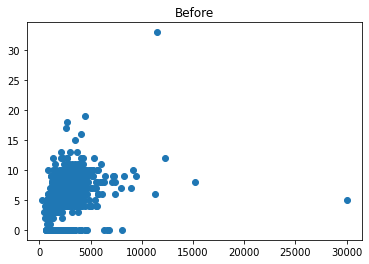

In [ ]:
# observe distribution before filling na
plt.scatter(df_cleaning.sqft_merged,df_cleaning.total_rooms)
plt.title('Before')
plt.show()

In [ ]:
# Turn 0 total rooms to nan
df_cleaning.loc[df_cleaning.total_rooms==0.0,'total_rooms'] = np.nan

# replace missing total rooms by backfilling with the number of rooms in listings that are most similar in terms of sqft, bedrooms, baths
df_cleaning.total_rooms = df_cleaning.sort_values(['sqft_merged','bedrooms_merged','total_baths'])['total_rooms'].fillna(method='bfill')

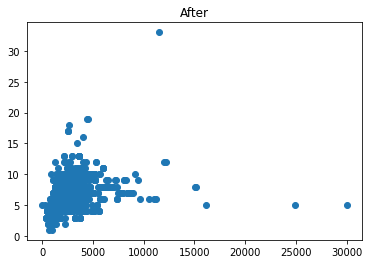

In [ ]:
# observe distribution after filling na
plt.scatter(df_cleaning.sqft_merged,df_cleaning.total_rooms)
plt.title('After')
plt.show()

## Stories

In [ ]:
# Replace listings with 0 stories with 1
df_cleaning.loc[df_cleaning.stories==0.0,'stories'] = 1

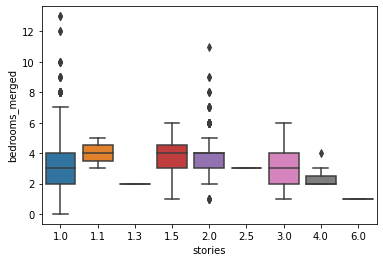

In [ ]:
# observe distribution before filling na
import seaborn as sns
sns.boxplot(x="stories", y="bedrooms_merged", data=df_cleaning)

In [ ]:
# replace missing stories by backfilling with the number of rooms in listings that are most similar in terms of sqft, bedrooms, baths
df_cleaning.stories = df_cleaning.sort_values(['sqft_merged','bedrooms_merged','total_baths'])['stories'].fillna(method='bfill')
df_cleaning.stories = df_cleaning.stories.astype(int)

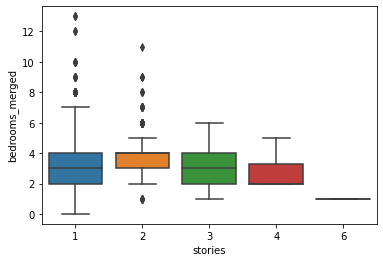

In [ ]:
# observe distribution after filling na
sns.boxplot(x="stories", y="bedrooms_merged", data=df_cleaning)

## "Has" Columns

In [ ]:
# for "has" columns, replace missingness with 'False', and binarize the feature
# assume that they do not have the feature if its missing 

df_cleaning.has_jacuzzi.fillna(value='False', inplace=True)
df_cleaning.has_jacuzzi.replace({'True':1,'False':0},inplace=True)
df_cleaning.has_jacuzzi = df_cleaning.has_jacuzzi.astype(int)

df_cleaning.has_central_air.fillna(value='False', inplace=True)
df_cleaning.has_central_air.replace({'True':1,'False':0},inplace=True)
df_cleaning.has_central_air = df_cleaning.has_central_air.astype(int)

df_cleaning.has_pool.fillna(value='False', inplace=True)
df_cleaning.has_pool.replace({'True':1,'False':0},inplace=True)
df_cleaning.has_pool = df_cleaning.has_pool.astype(int)

df_cleaning.has_solar.fillna(value='False', inplace=True)
df_cleaning.has_solar.replace({'True':1,'False':0},inplace=True)
df_cleaning.has_solar = df_cleaning.has_solar.astype(int)

df_cleaning.has_garage.fillna(value='False', inplace=True)
df_cleaning.has_garage.replace({'True':1,'False':0},inplace=True)
df_cleaning.has_garage = df_cleaning.has_garage.astype(int)

### Investigate "unfixable" columns that have a lot of missingness, and drop them

In [ ]:
cant_fix_cols = ['neighborhood', 'porch_or_patio','number_of_units', 'heating','property_quality','parking_features','water_source', 'garage_type',
                           'zoning_description', 'tax_amount', 'senior_community_indicator', 'laundry_features', 'cooling','cooling_enum', 'garage_spaces','garage_type_enum',
                           'hoa_fee_merged', 'zoning_code', 'school_district_name','school_district_id']
print(len(cant_fix_cols))

20


In [ ]:
(df_cleaning[cant_fix_cols].isna().sum()/df_cleaning.shape[0]).sort_values(ascending=False)

neighborhood                  0.975165
porch_or_patio                0.958013
number_of_units               0.942112
heating                       0.939789
property_quality              0.927997
parking_features              0.925317
water_source                  0.916384
garage_type_enum              0.905128
garage_type                   0.901554
tax_amount                    0.898696
zoning_description            0.897624
senior_community_indicator    0.852242
laundry_features              0.852064
cooling_enum                  0.850456
cooling                       0.835626
garage_spaces                 0.822226
hoa_fee_merged                0.736466
zoning_code                   0.657495
school_district_name          0.338753
school_district_id            0.329105
dtype: float64

In [ ]:
df_cleaning.drop('neighborhood',axis=1,inplace=True) # drop neighborhood bc too many missing, cant be filled
df_cleaning.drop('porch_or_patio',axis=1,inplace=True) # drop porch_or_patio bc too many missing, cant be filled
df_cleaning.drop('number_of_units',axis=1,inplace=True) # drop bc not relevant
df_cleaning.drop('heating',axis=1,inplace=True) # cant infer, too many missing
df_cleaning.drop('property_quality',axis=1,inplace=True) # cant infer (brick, stucco, concrete etc).
df_cleaning.drop('parking_features',axis=1,inplace=True) # too many different options, cant infer
df_cleaning.drop('water_source',axis=1,inplace=True) # cant infer
df_cleaning.drop('garage_type',axis=1,inplace=True) # cant infer
df_cleaning.drop('zoning_description',axis=1,inplace=True) # too sparse
df_cleaning.drop('tax_amount',axis=1,inplace=True) # cant infer
df_cleaning.drop('senior_community_indicator',axis=1,inplace=True) # true is too sparse
df_cleaning.drop('laundry_features',axis=1,inplace=True) # cant infer
df_cleaning.drop(['cooling','cooling_enum'],axis=1,inplace=True) # cant infer
df_cleaning.drop(['garage_spaces','garage_type_enum'],axis=1,inplace=True) # cant infer
df_cleaning.drop('hoa_fee_merged',axis=1,inplace=True) # cant infer
df_cleaning.drop('zoning_code',axis=1,inplace=True) # cant infer
df_cleaning.drop(['school_district_name','school_district_id'],axis=1,inplace=True) # cant infer

### View Updated Missingness

In [ ]:
df_cleaning.shape

(5597, 37)

In [ ]:
df_cleaning.describe()

,total_baths,total_rooms,stories,zipcode,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,price_merged,bedrooms_merged,full_baths_merged,half_baths_merged,year_built_merged,sqft_merged,land_sqft_merged,latitude_merged,longitude_merged,is_apt
count,5597.000000,5597.000000,5597.000000,5597.000000,5597.000000,5597.000000,5597.000000,5597.000000,5597.000000,5.597000e+03,5597.000000,5597.000000,5597.000000,5597.000000,5597.000000,5.597000e+03,5597.000000,5597.000000,5597.000000
mean,2.420186,6.083438,1.182955,91108.656602,0.104342,0.011792,0.046275,0.000179,0.082902,9.233252e+05,3.225299,2.393341,0.029257,1964.819546,1921.950688,2.801782e+04,34.128073,-118.289708,0.140075
std,1.144845,1.649292,0.431235,903.891335,0.305731,0.107959,0.210098,0.013367,0.275758,2.119728e+06,1.176134,1.119007,0.193035,25.668161,1208.738842,1.490040e+05,0.219200,0.223265,0.347096
min,0.030000,1.000000,1.000000,90001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.950000e+03,0.000000,0.000000,0.000000,1890.000000,1.000000,6.000000e+00,33.707248,-118.864849,0.000000
25%,2.000000,5.000000,1.000000,90278.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.750000e+05,3.000000,2.000000,0.000000,1949.000000,1245.000000,3.056000e+03,33.977955,-118.459781,0.000000
50%,2.000000,6.000000,1.000000,91208.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.298000e+05,3.000000,2.000000,0.000000,1961.000000,1623.000000,6.500000e+03,34.111141,-118.308042,0.000000
75%,3.000000,7.000000,1.000000,91401.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.888880e+05,4.000000,3.000000,0.000000,1985.000000,2264.000000,1.081500e+04,34.223653,-118.140103,0.000000
max,20.000000,33.000000,6.000000,93591.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.800000e+07,13.000000,20.000000,5.000000,2018.000000,30000.000000,6.946980e+06,34.786902,-117.653655,1.000000


In [ ]:
(df_cleaning.isna().sum()/df_cleaning.shape[0]).sort_values(ascending=False)

apt_num                  0.859925
free_texts_adjectives    0.761658
free_texts_nouns         0.761658
image_urls               0.216009
marketing_budget         0.000000
zipcode                  0.000000
address                  0.000000
match_street_address     0.000000
street_address           0.000000
property_type_x          0.000000
is_apt                   0.000000
pool_spa_types           0.000000
state_x                  0.000000
city_x                   0.000000
address_line             0.000000
county                   0.000000
total_rooms              0.000000
total_baths              0.000000
stories                  0.000000
has_central_air          0.000000
home_style               0.000000
full_baths_merged        0.000000
longitude_merged         0.000000
latitude_merged          0.000000
land_sqft_merged         0.000000
sqft_merged              0.000000
year_built_merged        0.000000
half_baths_merged        0.000000
bedrooms_merged          0.000000
has_jacuzzi   

In [ ]:
df_cleaning.columns

Index(['rex_url', 'total_baths', 'total_rooms', 'county', 'address_line',
       'city_x', 'state_x', 'stories', 'marketing_budget', 'property_type_x',
       'street_address', 'apt_num', 'match_street_address', 'address',
       'zipcode', 'image_urls', 'pool_spa_types', 'home_style',
       'has_central_air', 'has_jacuzzi', 'has_pool', 'has_solar', 'has_garage',
       'fencing_description', 'property_condition', 'price_merged',
       'bedrooms_merged', 'full_baths_merged', 'half_baths_merged',
       'year_built_merged', 'sqft_merged', 'land_sqft_merged',
       'latitude_merged', 'longitude_merged', 'free_texts_nouns',
       'free_texts_adjectives', 'is_apt'],
      dtype='object')

##Drop cols that wont work in siamese neural network

In [ ]:
ignore_for_siamese = ['image_urls', 'free_texts_nouns', 'free_texts_adjectives','address_line','street_address','match_street_address','address','apt_num','county','state_x']
df_siamese = df_cleaning.drop(ignore_for_siamese,axis=1).copy()

In [ ]:
df_siamese.columns = df_siamese.columns.str.replace('_x', '')
df_siamese.columns = df_siamese.columns.str.replace('_merged', '')

In [ ]:
print(len(df_siamese.columns))
df_siamese.columns

27


Index(['rex_url', 'total_baths', 'total_rooms', 'city', 'stories',
       'marketing_budget', 'property_type', 'zipcode', 'pool_spa_types',
       'home_style', 'has_central_air', 'has_jacuzzi', 'has_pool', 'has_solar',
       'has_garage', 'fencing_description', 'property_condition', 'price',
       'bedrooms', 'full_baths', 'half_baths', 'year_built', 'sqft',
       'land_sqft', 'latitude', 'longitude', 'is_apt'],
      dtype='object')

Started out with 56 Features
* Siamese won't use 10
* 20 were not salvageable 

### Use Realtor Metrics to encode further information about listings location (zipcode) 

Data Sources:
* https://www.realtor.com/research/data/

In [ ]:
# load in realtor data
realtor = pd.read_csv(f"./{FOLDER}/RDC_Inventory_Hotness_Metrics_Zip_History.csv")
realtor.head(2)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,month_date_yyyymm,postal_code,zip_name,nielsen_hh_rank,hotness_rank,hotness_rank_mm,hotness_rank_yy,hotness_score,supply_score,demand_score,median_days_on_market,median_days_on_market_mm,median_dom_mm_day,median_days_on_market_yy,median_dom_yy_day,median_dom_vs_us,ldpviews_per_property_mm,ldpviews_per_property_yy,ldpviews_per_property_vs_us,median_listing_price,median_listing_price_mm,median_listing_price_yy,median_listing_price_vs_us
0,202010,45805,"lima, oh",4919.0,5244.0,410.0,-3609.0,56.643658,29.845478,83.441839,65.0,0.0236,1.5,0.3265,16.0,12.0,0.093,0.8077,1.7279,179950.0,0.0432,0.2993,0.5141
1,202010,95632,"galt, ca",4602.0,1617.0,-1439.0,-1310.0,80.374931,71.252647,89.497215,39.0,1.1667,21.0,0.1642,5.5,-14.0,-0.229,0.8625,1.9926,550050.0,-0.0141,0.2076,1.5717


In [ ]:
# identify useful columns from realtor dataset
good_cols = ['month_date_yyyymm','postal_code','nielsen_hh_rank', 'hotness_score', 'demand_score', 'supply_score', 'median_days_on_market', 'median_listing_price',
             'ldpviews_per_property_vs_us']

realtor_filtered = realtor[realtor['postal_code'].isin(df_siamese.zipcode.unique())][good_cols].copy()
realtor_filtered.sort_values('month_date_yyyymm',ascending=False,inplace=True)
realtor_filtered.drop_duplicates('postal_code',keep='first',inplace=True)

realtor_filtered.drop('month_date_yyyymm',axis=1,inplace=True)

In [ ]:
# merge in location features from realtor
df_siamese_realtor = df_siamese.merge(realtor_filtered,left_on='zipcode',right_on='postal_code',how='left')
df_siamese_realtor.dropna(subset=['ldpviews_per_property_vs_us', 'median_days_on_market','supply_score','demand_score','hotness_score','nielsen_hh_rank','postal_code','median_listing_price'],inplace=True)
df_siamese_realtor.drop('postal_code',axis=1,inplace=True)

In [ ]:
(df_siamese_realtor.isna().sum()/df_siamese_realtor.shape[0]).sort_values(ascending=False)

ldpviews_per_property_vs_us    0.0
pool_spa_types                 0.0
has_garage                     0.0
has_solar                      0.0
has_pool                       0.0
has_jacuzzi                    0.0
has_central_air                0.0
home_style                     0.0
zipcode                        0.0
median_listing_price           0.0
property_type                  0.0
marketing_budget               0.0
stories                        0.0
city                           0.0
total_rooms                    0.0
total_baths                    0.0
fencing_description            0.0
property_condition             0.0
price                          0.0
bedrooms                       0.0
full_baths                     0.0
half_baths                     0.0
year_built                     0.0
sqft                           0.0
land_sqft                      0.0
latitude                       0.0
longitude                      0.0
is_apt                         0.0
nielsen_hh_rank     

In [ ]:
df_siamese_realtor.shape

(5575, 34)

## Investigate datatypes and categorical/embedding

In [ ]:
df_siamese_realtor.dtypes.sort_values()

has_pool                         int64
stories                          int64
has_central_air                  int64
has_jacuzzi                      int64
has_garage                       int64
has_solar                        int64
sqft                           float64
year_built                     float64
half_baths                     float64
full_baths                     float64
bedrooms                       float64
price                          float64
median_listing_price           float64
longitude                      float64
ldpviews_per_property_vs_us    float64
is_apt                         float64
nielsen_hh_rank                float64
hotness_score                  float64
demand_score                   float64
supply_score                   float64
median_days_on_market          float64
total_rooms                    float64
total_baths                    float64
land_sqft                      float64
latitude                       float64
rex_url                  

In [ ]:
# for the non-numeric features, how many unique values can they take on?
for i in df_siamese_realtor.dtypes[df_siamese_realtor.dtypes=='object'].index:
  print(i, df_siamese_realtor[i].nunique())

rex_url 5575
city 139
marketing_budget 3
property_type 5
zipcode 264
pool_spa_types 7
home_style 9
fencing_description 16
property_condition 10


## Transforming/Embedding city code, zipcode with tSNE

In [ ]:
df_siamese_categ = df_siamese_realtor.copy()

df_siamese_categ['city_code'] = df_siamese_categ['city'].astype("category").cat.codes

from sklearn.manifold import TSNE
data_subset = df_siamese_categ[['zipcode','city_code']].values
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5575 samples in 0.004s...
[t-SNE] Computed neighbors for 5575 samples in 0.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5575
[t-SNE] Computed conditional probabilities for sample 2000 / 5575
[t-SNE] Computed conditional probabilities for sample 3000 / 5575
[t-SNE] Computed conditional probabilities for sample 4000 / 5575
[t-SNE] Computed conditional probabilities for sample 5000 / 5575
[t-SNE] Computed conditional probabilities for sample 5575 / 5575
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.235893
[t-SNE] KL divergence after 300 iterations: 1.037306


In [ ]:
df_siamese_categ.drop(['zipcode','city_code','city'],axis=1,inplace=True)
df_siamese_categ['loc_tsne_1'] = tsne_results[:,0]
df_siamese_categ['loc_tsne_2'] = tsne_results[:,1]

## Onehot encoding other categorical features

In [ ]:
# one-hot-encoding for some categorical features
cat_features = ['marketing_budget', 'property_type', 'pool_spa_types', 'home_style', 'fencing_description', 'property_condition']

# join the one-hot encoded features dataframe with original one
for feature in cat_features:
    transformed_df = pd.get_dummies(df_siamese_categ[feature], prefix='1hot_'+feature)
    df_siamese_categ = df_siamese_categ.join(transformed_df)

# drop the original categorical features
df_siamese_categ.drop(columns=cat_features,inplace=True)

In [ ]:
df_siamese_categ.head()

,rex_url,total_baths,total_rooms,stories,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,price,bedrooms,full_baths,half_baths,year_built,sqft,land_sqft,latitude,longitude,is_apt,nielsen_hh_rank,hotness_score,demand_score,supply_score,median_days_on_market,median_listing_price,ldpviews_per_property_vs_us,loc_tsne_1,loc_tsne_2,1hot_marketing_budget_LOW,1hot_marketing_budget_MEDIUM,1hot_marketing_budget_SURGE,1hot_property_type_CONDO,1hot_property_type_COOP,1hot_property_type_MULTI_FAMILY,1hot_property_type_SINGLE,1hot_property_type_TOWNHOUSE,1hot_pool_spa_types_Community Pool or Spa,1hot_pool_spa_types_Heated Pool,1hot_pool_spa_types_In Ground,1hot_pool_spa_types_No,1hot_pool_spa_types_Pool & Spa (both),1hot_pool_spa_types_Pool (yes),1hot_pool_spa_types_Spa (only),1hot_home_style_Bungalow,1hot_home_style_Cape Cod,1hot_home_style_Contemporary,1hot_home_style_Mediterranean,1hot_home_style_Modern,1hot_home_style_Other,1hot_home_style_Ranch/Rambler,1hot_home_style_Spanish,1hot_home_style_Traditional,1hot_fencing_description_Average Condition,1hot_fencing_description_Back Yard,1hot_fencing_description_Block,1hot_fencing_description_Block Wall,1hot_fencing_description_Chain Link,1hot_fencing_description_Excellent Condition,1hot_fencing_description_Good Condition,1hot_fencing_description_None,1hot_fencing_description_Other,1hot_fencing_description_Other/Remarks,1hot_fencing_description_Partial,1hot_fencing_description_Privacy,1hot_fencing_description_Stucco Wall,1hot_fencing_description_Vinyl,1hot_fencing_description_Wood,1hot_fencing_description_Wrought Iron,1hot_property_condition_Additions/Alter,1hot_property_condition_Additions/Alterations,1hot_property_condition_Building Permit,1hot_property_condition_Fixer,1hot_property_condition_Other,1hot_property_condition_Repairs Cosmetic,1hot_property_condition_Repairs Major,1hot_property_condition_Termite Clearance,1hot_property_condition_Turnkey,1hot_property_condition_Updated/Remodeled
0,rex1-pacific-coast-hwy,12.0,33.0,1,0,0,0,0,0,44000000.0,12.0,2.0,0.0,2015.0,11510.0,141570.0,34.023865,-118.787080,0.0,6211.0,23.044945,44.348576,1.741313,221.0,4900050.0,0.9191,4.173980,6.034126,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4080-glencoe-ave-unit-316,2.0,5.0,1,0,0,0,0,0,1099000.0,1.0,2.0,0.0,2011.0,1580.0,17336.0,33.990732,-118.441965,1.0,2196.0,6.741705,3.992470,9.490940,106.0,1388050.0,0.2721,9.119221,13.400335,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,175-sequoia-dr,2.0,7.0,1,0,0,0,0,0,943900.0,3.0,2.0,0.0,1958.0,1747.0,7475.0,34.138413,-118.180510,0.0,7326.0,40.732606,22.315476,59.149737,45.0,1795050.0,0.6103,4.947028,-2.144489,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,6560-3rd-ave,1.0,5.0,1,0,0,0,0,0,439000.0,2.0,1.0,0.0,1925.0,1168.0,4814.0,33.979654,-118.320367,0.0,1424.0,4.902345,5.953408,3.851282,154.0,800050.0,0.3309,-5.425113,-6.002894,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1258-barry-ave-unit-5,2.0,4.0,1,0,0,0,0,0,1250000.0,3.0,2.0,0.0,1998.0,2521.0,6901.0,34.048821,-118.458578,1.0,397.0,36.587183,2.972782,70.201584,40.0,1049050.0,0.2353,16.086262,-3.644751,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Transform numeric features

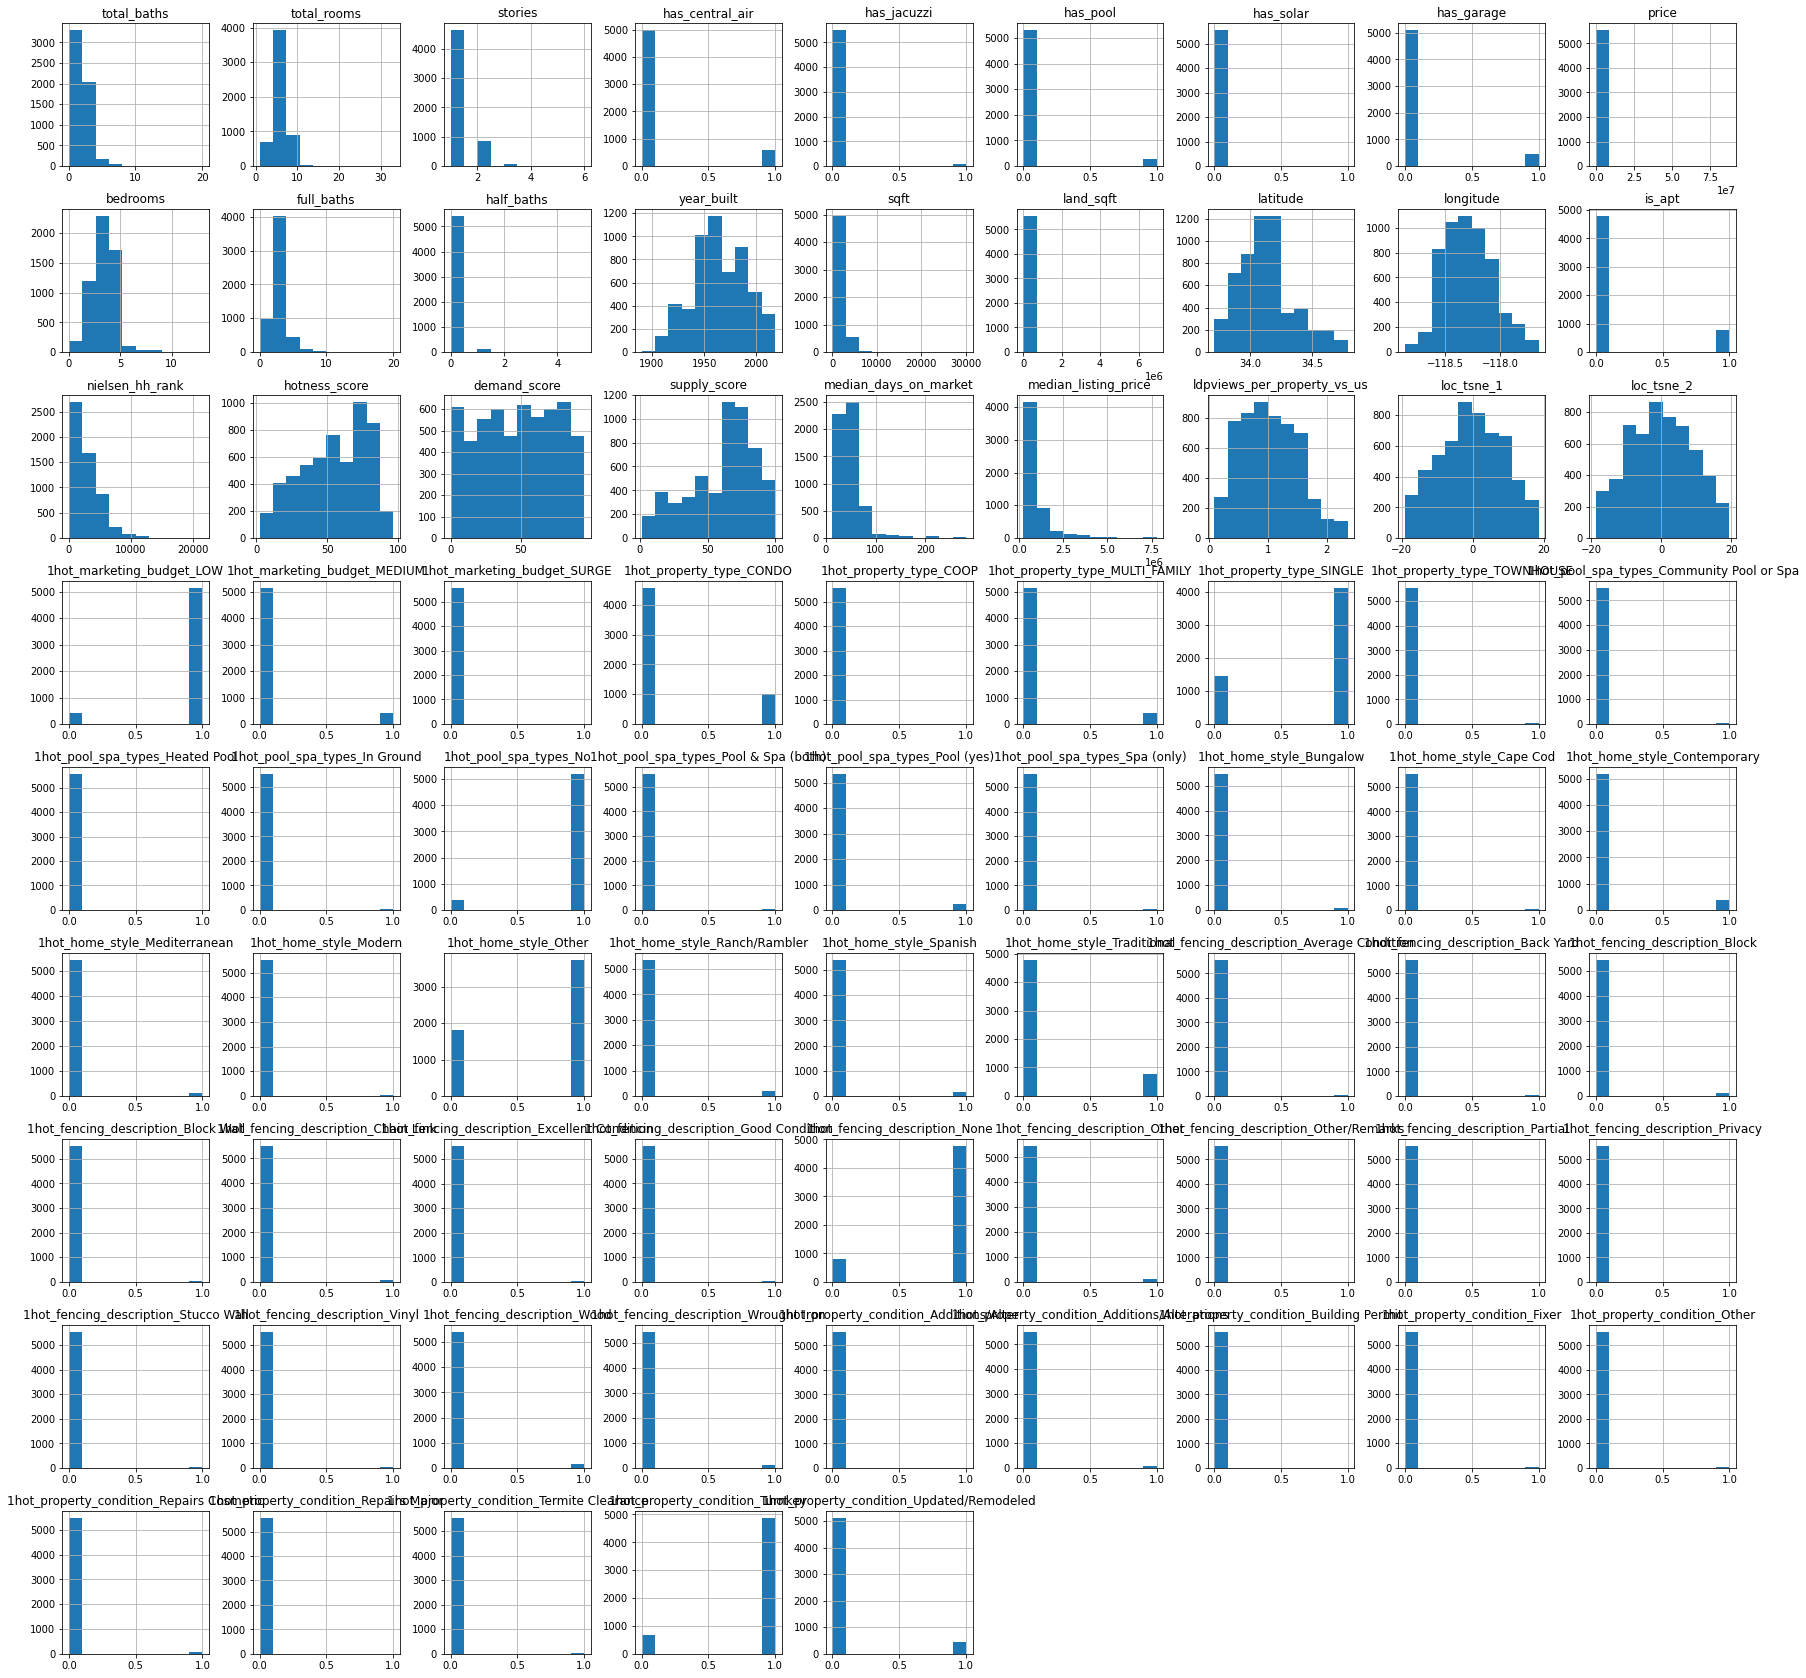

In [ ]:
df_siamese_categ.hist(figsize=(30,30))
plt.show()

In [ ]:
# Take logs of numeric features to fix skewed distributions
df_siamese_final_log = df_siamese_categ.copy()

df_siamese_final_log['log_price'] = np.log(df_siamese_categ.price)
df_siamese_final_log['log_sqft'] = np.log(df_siamese_categ.sqft)
df_siamese_final_log['log_median_listing_price'] = np.log(df_siamese_categ.median_listing_price)
df_siamese_final_log['log_median_days_on_market'] = np.log(df_siamese_categ.median_days_on_market)
df_siamese_final_log['log_nielsen_hh_rank'] = np.log(df_siamese_categ.nielsen_hh_rank)
df_siamese_final_log['log_land_sqft'] = np.log(df_siamese_categ.land_sqft)
df_siamese_final_log['log_total_rooms'] = np.log(df_siamese_categ.total_rooms)

df_siamese_final_log.drop(['price','sqft','median_listing_price','median_days_on_market','nielsen_hh_rank','land_sqft','total_rooms'],axis=1,inplace=True)

## Saving Out Final Listing Dataset (for use in siamese NN and other models)

In [ ]:
df_siamese_final = df_siamese_categ.copy()
df_siamese_final.to_pickle('siamese_data_11_12.pkl')

In [ ]:
df_siamese_final_log.to_pickle('LOG_siamese_data_11_12.pkl')

In [ ]:
df_siamese_final_log.shape

(5575, 78)

# Adding in additional Image Features (post- sytle clustering analysis)

In [ ]:
# Bring in image style features
img_features = pd.read_csv('final_img_features.csv')
img_features.drop(['listing_id','averaged_pca_features'],axis=1,inplace=True)

In [ ]:
img_features.head(2)

In [ ]:
# merge in the image features
final_listing_data = df_siamese_final_log.merge(img_features,on='rex_url',how='left')

In [ ]:
# Find columns with NAs
listing_nas = final_listing_data.isna().sum()
listing_nas[listing_nas>0]

In [ ]:
# Fill missing image data with -1 indicator
final_listing_data.fillna(value=-1, inplace=True)

In [ ]:
# Save listing data
final_listing_data.to_pickle('listing_data_filtered_with_img.pkl')